# Intro to JuMP

Now that we are familiar with Julia syntax and packages, let's take a look at how to build linear programs in Julia using the JuMP package! 

### Notebook outline

1. Build and solve a simple model! (Easy peasy)
2. Incorporate some fancier data pre-processing
3. Build and solve a large number of similar LPs (modularize!)

_Note_: The preassignment did not include packages Distances, Random, and StatsBase; please install those by uncommenting the line below.

In [ ]:
# using Pkg; Pkg.add("Distances"); Pkg.add("StatsBase"); Pkg.add("Random")

In [1]:
using JuMP, Gurobi, CSV, DataFrames, Plots, Distances, StatsBase, Random

const GRB_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12


## 1. Building and solving simple models

Let's check out the basic syntax of building a linear program in Julia with JuMP.

How would be formulate the following?

\begin{align}
\min \quad &e'x \\
\text{s.t. } \quad &A x\geq b \\
&x \geq 0
\end{align}

In [60]:
#--- generate random parameters 
n = 10
A = round.(rand(n, n), digits=2)   # random resource matrix
b = round.(rand(n) * 5, digits=2); # randm demand

In [61]:
#--- construct the model
m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource, A*x .>= b)
JuMP.@objective(m, Min, sum(x));

In [63]:
#--- look at it!
JuMP.latex_formulation(m)

$$ \begin{aligned}
\min\quad & x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6} + x_{7} + x_{8} + x_{9} + x_{10}\\
\text{Subject to} \quad & 0.31 x_{1} + 0.99 x_{2} + 0.55 x_{3} + 0.65 x_{4} + 0.53 x_{5} + 0.04 x_{6} + 0.32 x_{7} + 0.9 x_{8} + 0.57 x_{9} + 0.37 x_{10} \geq 0.53\\
 & 0.24 x_{1} + 0.9 x_{2} + 0.05 x_{3} + 0.44 x_{4} + 0.35 x_{5} + 0.26 x_{6} + 0.79 x_{7} + 0.03 x_{8} + 0.36 x_{9} + 0.77 x_{10} \geq 0.6\\
 & 0.55 x_{1} + 0.89 x_{2} + 0.95 x_{3} + 0.65 x_{4} + 0.78 x_{5} + 0.75 x_{6} + 0.64 x_{7} + 0.21 x_{8} + 0.39 x_{9} + 0.53 x_{10} \geq 2.99\\
 & 0.09 x_{1} + 0.62 x_{2} + 0.04 x_{3} + 0.96 x_{4} + 0.03 x_{5} + 0.89 x_{6} + 0.28 x_{7} + 0.25 x_{8} + 0.35 x_{9} + 0.53 x_{10} \geq 3.4\\
 & 0.51 x_{1} + 0.46 x_{2} + 0.74 x_{3} + 0.7 x_{4} + 0.9 x_{5} + 0.75 x_{6} + 0.68 x_{7} + 0.88 x_{8} + 0.79 x_{9} + 0.89 x_{10} \geq 3.85\\
 & 0.7 x_{1} + 0.87 x_{2} + 0.66 x_{3} + 0.32 x_{4} + 0.86 x_{5} + 0.17 x_{6} + 0.88 x_{7} + 0.25 x_{8} + 0.27 x_{9} + 0.32 x_{10} \geq 2.63\\
 & 0.05 

In [64]:
#--- solve!
JuMP.optimize!(m)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 10 columns and 100 nonzeros
Model fingerprint: 0x976ab350
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 5e+00]
Presolve time: 0.00s
Presolved: 10 rows, 10 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.409000e+01   0.000000e+00      0s
       3    7.4779074e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.477907418e+00

User-callback calls 40, time in user-callback 0.00 sec


In [67]:
#--- optimal value?
obj = JuMP.objective_value(m)

7.477907417873816

### That's quite the print-out! What do we do with it? 
The solver log has some useful information! ([Here](https://www.gurobi.com/documentation/9.5/refman/logging.html) is a comprehensive summary of Gurobi logging.)

* Summary of model size
* Parameter ranges (troubleshoot numerical errors)
* Dual simplex solution progress
    * Objective value of current basis
    * Magnitudes of primal and dual infeasibility
    * Iteration and time elapsed
* Objective value
* Tottal solve time
* Callback summaries

However, if you want to turn it off...

In [51]:
solver = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0)
m = JuMP.Model(solver)

# while we're at it... an equivalent way to formulate, without matrix ops
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource[i=1:n], sum(A[i,j] * x[j] for j in 1:n) >= b[i])
JuMP.@objective(m, Min, sum(x[j] for j in 1:n));

In [49]:
#--- so quiet...
JuMP.optimize!(m)

In [66]:
#--- equivalent?
JuMP.objective_value(m) == obj

true

### Common model queries

What other information do we want to squeeze out of our model?
* Primal and dual solutions
* Termination status (possible outcomes [here](https://jump.dev/JuMP.jl/stable/moi/reference/models/#MathOptInterface.TerminationStatusCode))

In [70]:
@show JuMP.value.(x);                # primal solution

JuMP.value.(x) = [0.0, 0.6840687204341865, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.78336339916848, 4.01047529827115]


In [71]:
@show JuMP.shadow_price.(resource);  # dual solution

JuMP.shadow_price.(resource) = [-0.0, -0.0, -0.0, -0.0, -0.0, -0.48524709471125194, -0.0, -0.5845417734455446, -0.9281052330037703, -0.0]


In [72]:
@show JuMP.termination_status(m);     # did the model get solved to optimality?

JuMP.termination_status(m) = MathOptInterface.OPTIMAL


TODO: model attributes

### Exercise

Implement and solve the dual of our tiny optimization model up there. Verify that you get the same objective value!

In [81]:
#--- code here
d = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
JuMP.set_silent(d)
JuMP.@variable(d, p[1:n]>= 0)
JuMP.@constraint(d, A'p .<= 1)
JuMP.@objective(d, Max, b'p)
JuMP.optimize!(d)
abs(JuMP.objective_value(d) - obj) < 1e-5

true

## 2. Building a model with fancy data pre-processing

That was great and all, but what about the unsexy side of things where I have a bunch of datasets that I need to translate into model inputs? How do I do that and stay organized?? Let's set up a case study.

Massachusetts needs to make sure that its citizens are vaccinated from Omicron during March, April, and May. Everyone should get vaccinated. Let's respect a statewide budget and minimize total distance traveled by those being vaccinated. Where should MA set up temporary mass vaccination sites?

**Sets**
* Days $T = \{1, \dots, 92\}$
* Cities and towns $C$
* Potential vaccination facilities $F$

**Parameters**
* $r_{jt}$ - number of persons in city $j \in C$ who need to be vaccinated on day $t \in T$
* $d_{ij}$ - distance from facility $i \in F$ to city $j \in C$ (assume the same for everyone in area $j$)
* $K_i$ - fixed cost of opening facility $i \in F$ 
* $v_{it}$ - operating cost for keeping facility $i \in F$ open on day $t \in T$
* $P_i$ - number of persons who can be vaccinated at facility $i \in F$ each day, assuming the facility is open
* $B$ - budget for opening facilities
* $L$ - maximum number of vaccination sites open

**Decisions**
* $x_{ijt}$ - number of people in city $j \in C$ vaccinated at site $i \in F$ on day $t \in T$
* $y_{it}$ - whether facility $i \in F$ is opened on day $t \in T$
* $z_i$ - whether facility $i \in F$ is open

**Formulation**

\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} \sum_{t \in T} d_{ij} \cdot x_{ijt} \\
\text{s.t. } \quad &\sum_{i \in F} \Big(K_i \cdot z_i + \sum_{t \in T} v_{it} \cdot y_{it} \Big) \leq B \\
&\sum_{i \in F} z_i \leq L && &&\text{Budget}\\
&y_{it} \leq z_i &&i \in F, t \in T &&\text{Link opening decisions} \\
&\sum_{j \in C}x_{ijt} \leq P_i \cdot y_{it} &&i \in F, t \in T &&\text{Capacity} \\
&\sum_{i \in F}x_{ijt} = r_{jt} &&j \in C, t \in T &&\text{Demand} \\
&x_{ijt} \geq 0 &&i \in F, j \in C, t \in T \\
&y_{it} \in \{0,1\} &&i \in F, t \in T \\
&z_i \in \{0,1\} &&i \in F
\end{align}

### 2.0 From raw data to formatted data

* MA population at ZIP code level ([source](https://censusreporter.org/data/table/?table=B01003))
* Prettier ZIP code names ([source](https://www.zip-codes.com/state/ma.asp))
* Potential facility locations and their capacities/costs (source: simulated!)
* Vaccination schedule (source: simulated with population data)

I formatted the data in Python to obtain the centroids of each ZIP code. If you want to see how that was done, the script is in the raw data directory.

### 2.1 From formatted data to model inputs

Let's read in our formatted data toward constructing the sets and parameters that we need.

In [2]:
#--- data paths and constants
data_dir = joinpath("data", "formatted")
pop_fn = joinpath(data_dir, "ma_population.csv")
fac_fn = joinpath(data_dir, "facilities.csv")
sched_fn = joinpath(data_dir, "schedule.csv")

hav = Distances.Haversine(3958.8); # radius of Earth in miles

In [3]:
#--- schedule data (simulated)
sched = CSV.read(sched_fn, DataFrame)

,day,01001,01002,01003,01005,01007,01008,01009,01010,01011,01012,01013
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,211,322,124,59,154,19,2,56,16,11,234
2,2,191,335,132,64,166,11,2,48,14,3,224
3,3,172,347,111,57,152,12,3,45,15,5,254
4,4,172,338,125,61,166,14,5,40,14,9,221
5,5,195,309,133,49,153,17,4,38,10,10,243
6,6,168,321,101,51,152,9,2,45,11,11,247
7,7,190,294,121,47,138,12,2,41,18,7,236
8,8,173,298,121,51,173,20,4,41,18,7,247
9,9,195,326,89,75,175,8,2,45,17,7,233


In [4]:
#--- population data
pop_dat = DataFrame(CSV.File(pop_fn))

,geoid,population,pop_error,longitude,latitude,city,county
,String15,Float64,Float64,Float64,Float64,String31?,String15?
1,86000US01001,17312.0,735.0,-72.6259,42.0626,Agawam,Hampden
2,86000US01002,30014.0,485.0,-72.4621,42.3749,Amherst,Hampshire
3,86000US01003,11357.0,477.0,-72.5248,42.3919,Amherst,Hampshire
4,86000US01005,5128.0,404.0,-72.1062,42.4202,Barre,Worcester
5,86000US01007,15005.0,20.0,-72.4004,42.2787,Belchertown,Hampshire
6,86000US01008,1140.0,178.0,-72.952,42.1843,Blandford,Hampden
7,86000US01009,261.0,198.0,-72.3397,42.2097,Bondsville,Hampden
8,86000US01010,3658.0,17.0,-72.2062,42.1286,Brimfield,Hampden
9,86000US01011,1430.0,170.0,-72.9597,42.2965,Chester,Hampden


In [5]:
#--- facility data (simulated)
fac_dat = CSV.read(fac_fn, DataFrame)

,latitude,longitude,capacity,fixed_cost,var_cost,facility_id
,Float64,Float64,Float64,Float64,Float64,String7
1,42.0455,-72.651,3856.0,1.74271e5,17400.2,fac1
2,42.4003,-72.5327,6617.0,3.01291e5,30102.2,fac2
3,42.372,-72.6098,2561.0,1.14721e5,11445.2,fac3
4,42.4228,-72.1624,1207.0,52431.1,5216.19,fac4
5,42.2725,-72.3967,3354.0,1.51201e5,15093.2,fac5
6,42.1206,-72.9685,340.0,12551.1,1228.19,fac6
7,42.279,-72.3277,149.0,3761.15,349.187,fac7
8,42.0984,-72.2021,887.0,37731.1,3746.19,fac8
9,42.2109,-72.9672,403.0,15451.1,1518.19,fac9


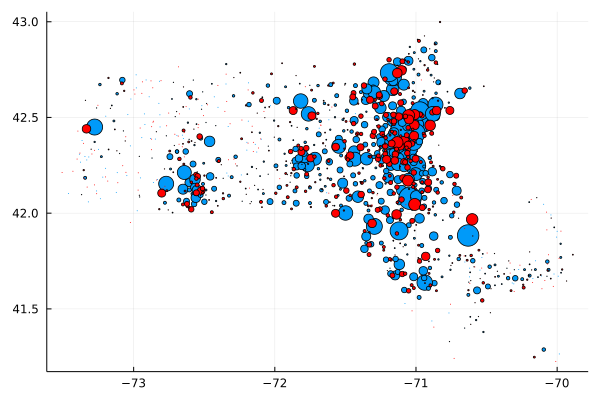

In [221]:
#--- visualize
scatter(pop_dat[:, "longitude"], pop_dat[:, "latitude"], markersize=0.0002*pop_dat[:, "population"], legend=false)
scatter!(fac_dat[:, "longitude"], fac_dat[:, "latitude"], color="red", markersize=0.0005*fac_dat[:, "capacity"])

We have a facility in each zip code. Seems that daily capacity at each facility is somewhat correlated with the zip code's population.

For the record, this is way too many facilities to consider without using large-scale decomposition methods. Our order of magnitude will be: 

In [22]:
nrow(pop_dat) * nrow(fac_dat) * 92

27326300

Yikes! We will take that into account later.

### What input formatting needs to be done?

Some model attributes are straightforward translations of dataframe columns:
* city and facility IDs - $C, F$
* facility capacities - $P$
* fixed and variable facility costs - $K, v$
* demand - $r$

Others are constants:
* budget - $B$
* max number of facilities - $L$
* number of days - $T$

And some need to be computed:
* distances between facilities and residents - $d$

### Collecting all of the model components

This is a lot of stuff to keep track of. How can I keep everything organized?

We will create a Julia struct, which is a flexible data structure that can keep track of attributes of all types. If you are familiar with Python, a struct is analogous to a class, but we cannot assign methods to it.

In [6]:
struct FacilityLocationData
    #--- constants 
    L::Int64        # location limit
    B::Float64      # budget
    
    #--- sets
    T::Vector{Int64}   # days
    C::Vector{String}  # zip codes 
    F::Vector{String}  # facility IDs
    
    #--- parameters
    r::Dict{Tuple{String,Int64},Int64}     # demand 
    P::Dict{String,Int64}                  # daily capacity
    K::Dict{String,Float64}                # fixed cost
    v::Dict{String,Float64}                # variable cost
    d::Dict{Tuple{String,String},Float64}  # distances
    
    #--- extra information
    population::Dict{String,Int64}               # total populations
    city_county::Dict{String,String}             # city/county zip code map
    pop_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each zip code
    fac_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each facility
end

We cannot change the struct once it has been created. If we want to be able to change values, we create a mutable struct instead. (Just put the word "mutable" in front of struct at the top of the previous cell.)

Let's build a constructor for our FacilityLocationData data structure. We are taking advantage of the fact that Julia functions can have many _methods_.

In [34]:
"""
CONSTRUCTOR

### Keywords
* `pop_fp` - MA population filepath
* `fac_fp` - facility location filepath
* `sched_fp` - schedule filepath
* `L` - max facility locations that can be opened
* `B` - budget
* `num_facilities` - number of facilities to consider
"""
function FacilityLocationData(
        pop_fp::String,
        fac_fp::String,
        sched_fp::String,
        L::Int64=20,
        B::Float64=15e7,
        num_facilities::Int64=50
    )
    # read in raw data
    # note: this code is redundant with the above code, but that was preliminary data exploration!
    pop_dat = CSV.read(pop_fp, DataFrame)
    pop_dat[:, "zip_code"] = replace.(pop_dat[:, "zip_code"], "z" => "")
    sched = CSV.read(sched_fp, DataFrame)

    # reduce cardinality of facilities considered
    fac_dat = CSV.read(fac_fp, DataFrame)
    fac_idx = StatsBase.sample(1:nrow(fac_dat), num_facilities, replace=false)
    fac_dat = fac_dat[fac_idx, :]
    
    # sets
    T = [t for t in 1:maximum(sched[:, "day"])]
    C = String.(pop_dat[:, "zip_code"])
    F = String.(fac_dat[:, "facility_id"])
    
    # some extra info available in the pop dataframe
    pop = Dict{String,Int64}(
        pop_dat[:, "zip_code"] .=> pop_dat[:, "population"]
    )
    city_county = Dict{String,String}(
        row["zip_code"] => row["city"] .* ", " .* row["county"] for row in eachrow(pop_dat) 
            if (!ismissing(row["city"]) & !ismissing(row["county"]))
    )
    pop_gps = Dict{String,Tuple{Float64,Float64}}(
        pop_dat[:, "zip_code"] .=> tuple.(pop_dat[:, "latitude"], pop_dat[:, "longitude"])
    )
    fac_gps = Dict{String,Tuple{Float64,Float64}}(
        fac_dat[:, "facility_id"] .=> tuple.(fac_dat[:, "latitude"], fac_dat[:, "longitude"])
    )

    # facility parameters
    P = Dict{String,Int64}(F .=> fac_dat[:, "capacity"])
    K = Dict(F .=> fac_dat[:, "fixed_cost"])
    v = Dict(F .=> fac_dat[:, "var_cost"])
    
    # population parameters
    r = Dict{Tuple{String,Int64},Int64}(
        (name, row[:day]) => row[name] for row in eachrow(sched) for name in setdiff(names(sched), ["day"])
    )
                
    # distances
    d = Dict{Tuple{String,String},Float64}(
        (res, fac) => Distances.evaluate(hav, rgps, fgps) for (res, rgps) in pop_gps for (fac, fgps) in fac_gps
    )
                            
    return FacilityLocationData(L, B, T, C, F, r, P, K, v, d, pop, city_county, pop_gps, fac_gps)
end

FacilityLocationData

In [41]:
Random.seed!(47)
FLD = FacilityLocationData(pop_fn, fac_fn, sched_fn);

Now we can access any model attribute by name. Try it out!

In [42]:
@show FLD.T
@show FLD.F;

FLD.T = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
FLD.F = ["fac155", "fac228", "fac233", "fac25", "fac58", "fac328", "fac368", "fac231", "fac454", "fac369", "fac305", "fac196", "fac241", "fac147", "fac150", "fac288", "fac218", "fac312", "fac71", "fac94", "fac301", "fac65", "fac22", "fac441", "fac539", "fac17", "fac61", "fac440", "fac326", "fac175", "fac238", "fac227", "fac102", "fac467", "fac355", "fac62", "fac197", "fac215", "fac459", "fac258", "fac335", "fac91", "fac478", "fac314", "fac455", "fac505", "fac11", "fac428", "fac451", "fac345"]


What was the point of all of that? Can't we just use the parameter names themselves?

Well, good extensible code is _modularized_! By limiting all of our model components to one data structure, we have drastically simplified the arguments to any functions that build and solve models.

We want code that looks roughly like this:

```
FLD = FacilityLocationData(data_dir)
model = build_model(FLD)
solution = solve_model(model)
```

Look how lovely and legible that is! As we know, line 1 hides a lot of work. But now we have designed narrative, extensible code. If we need more info, we can go to the function(s) containing that info. Let's get to work on lines 2 and 3...

### 2.2 Model formulation

Now what? Let's work on `build_model` and `solve_model` functions.



### Exercise

Formulate the above model in JuMP using the inputs we just formatted.

Before you begin, here is some syntax that may be useful.

```
@variables m begin
    variable1_name >= 0
    variable2_name, Bin
end

@constraints m begin
    constraint1
    constraint2_index, constraint2
end
```

The above is a less verbose, equivalent way of coding:
```
@variable(m, variable1_name >= 0)
@variable(m, variable2_name, Bin)
@constraint(m, constraint1)
@constraint(m, constraint2_index, constraint2)
```

As a reminder, here's the formulation.

\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} \sum_{t \in T} d_{ij} \cdot x_{ijt} \\
\text{s.t. } \quad &\sum_{i \in F} \Big(K_i \cdot z_i + \sum_{t \in T} v_{it} \cdot y_{it} \Big) \leq B \\
&\sum_{i \in F} z_i \leq L && &&\text{Budget}\\
&y_{it} \leq z_i &&i \in F, t \in T &&\text{Link opening decisions} \\
&\sum_{j \in C}x_{ijt} \leq P_i \cdot y_{it} &&i \in F, t \in T &&\text{Capacity} \\
&\sum_{i \in F}x_{ijt} = r_{jt} &&j \in C, t \in T &&\text{Demand} \\
&x_{ijt} \geq 0 &&i \in F, j \in C, t \in T \\
&y_{it} \in \{0,1\} &&i \in F, t \in T \\
&z_i \in \{0,1\} &&i \in F
\end{align}

In [18]:
"""
Build MA facility location model.

### Keywords 
* `FLD` - FacilityLocationData
### Returns
* JuMP.Model representation of MA's mass vaccination site problem
"""
function build_model(FLD::FacilityLocationData)
    m = JuMP.Model(Gurobi.Optimizer)
    
    @variables m begin 
        x[FLD.F, FLD.C, FLD.T] >= 0
        y[FLD.F, FLD.T], Bin
        z[FLD.F], Bin
    end
    
    @constraints m begin 
        # budget
        sum(FLD.K[i] * z[i] for i in FLD.F + sum(FLD.v[i] * y[i, t] for t in FLD.T)) <= FLD.B
        # number of locations
        sum(z) <= FLD.L
        # link opening decisions
        [i in FLD.F, t in FLD.T], y[i,t] <= z[i]
        # capacities
        [i in FLD.F, t in FLD.T], sum(x[i,:,t]) <= FLD.P[i] * y[i,t]
        # demand
        [j in FLD.C, FLD.T], sum(x[:,j,t]) == FLD.r[(j, t)]
    end
    
    @objective(m, Min, sum(FLD.d[(i,j)] * x[i,j,:] for i in FLD.F for j in FLD.C))
                    
    return m
end

build_model

In [43]:
#--- let's try it out!
m = build_model(FLD)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12


LoadError: Repeated index 01062. Index sets must have unique elements.

# Appendix

Here's how the facility data was simulated.

In [230]:
# using Pkg; Pkg.add("Distributions")
using Distributions, Random
Random.seed!(47)
pop_vec = pop_dat[:, "population"]

# distributions
dist_lat = Normal.(pop_dat[:,"latitude"], 0.05)
dist_lon = Normal.(pop_dat[:, "longitude"], 0.05)
dist_cap = Normal(100, 10)
dist_fc = Normal(1e3, 100)

# locations (who knows if these are even in MA? on land??? oh well!)
fac_lat = rand.(d_lat)
fac_lon = rand.(d_lon)

# parameters
P = max.(round.(pop_vec ./ 92 .* 20 .+ rand(dist_cap)), 0)
K = pop_vec .* 10 .+ rand(dist_fc)
v = pop_vec .+ rand(dist_cap)

# facility IDs
facility_id = "fac" .* string.([i for i in 1:length(fac_lat)])

# format into a CSV
facilities = DataFrame(latitude = fac_lat, longitude = fac_lon, capacity = P, fixed_cost = K, var_cost = v, facility_id = facility_id)
CSV.write(joinpath("data", "formatted", "facilities.csv"), facilities);

The schedules were simulated by drawing from Multinomial($population$, $92$) distributions for each zip code.